In [1]:
import sys
import os

# Add the project root directory to the Python path
project_root = os.path.abspath("..")  # Adjust based on your folder structure
sys.path.append(project_root)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import importlib
from collections import deque
import random
import numpy as np
import matplotlib.pyplot as plt
from tactix.utils import *
from tactix.tactixEnvironment_v2 import TactixEnvironment
from tactix.tactixGame import TactixGame
import matplotlib.pyplot as plt
import os

importlib.reload(sys.modules['tactix.tactixGame'])
importlib.reload(sys.modules['tactix.tactixEnvironment_v2'])
importlib.reload(sys.modules['tactix.utils'])

<module 'tactix.utils' from '/Users/alibal/Desktop/tactix-game/tactix/utils.py'>

In [3]:
random.seed(42)

In [5]:
class DQN(nn.Module):
    """
    A DQN with a single attention layer after the input state.
    """
    def __init__(self, state_size, action_size, layer_sizes):
        super(DQN, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        
        # Attention layer
        self.attention_layer = nn.Linear(state_size, state_size)
        self.attention_activation = nn.Softmax(dim=-1)  # Softmax to generate attention weights
        
        # Hidden layers
        layers = []
        input_dim = state_size
        for hidden_size in layer_sizes:
            layers.append(nn.Linear(input_dim, hidden_size))
            layers.append(nn.ReLU())
            input_dim = hidden_size
        
        # Final layer: from the last hidden layer to the action output
        layers.append(nn.Linear(input_dim, action_size))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        """
        Forward pass through the DQN with an attention layer.
        x: Input state tensor, shape [batch_size, state_size].
        """
        # Attention mechanism
        attention_weights = self.attention_activation(self.attention_layer(x))  # [batch_size, state_size]
        x = x * attention_weights  # Apply attention weights to the input
        
        # Pass through the rest of the network
        return self.network(x)  # Outputs Q-values for each action

In [6]:
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, transition):
        """Store a transition (s, a, r, s')"""
        self.memory.append(transition)

    def sample(self, batch_size):
        """Sample a batch of transitions"""
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [7]:
class DQNAgent:
    def __init__(
        self, 
        state_size, 
        action_size, 
        layer_sizes,
        lr=1e-3, 
        gamma=0.9, 
        epsilon_start=1.0, 
        epsilon_end=0.01, 
        epsilon_decay=0.999876,
        memory_capacity=10000,
        device='cpu'
    ):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.device = device
        
        # Q-Networks (main + target)
        self.q_network = DQN(state_size, action_size, layer_sizes).to(self.device)
        self.target_network = DQN(state_size, action_size, layer_sizes).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()

        # Optimizer
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)

        # Replay Memory
        self.memory = ReplayMemory(capacity=memory_capacity)

    def select_action(self, state, valid_moves_mask):
        """
        Epsilon-greedy action selection with invalid move masking.
        state: shape (1, state_size)
        valid_moves_mask: shape (1, action_size) -> 1/0 for valid moves
        """
        if random.random() < self.epsilon:
            valid_indices = torch.where(valid_moves_mask[0] == 1)[0]
            action = random.choice(valid_indices.tolist())
            return action
        else:
            with torch.no_grad():
                q_values = self.q_network(state.to(self.device))  # (1, action_size)
                # Mask invalid actions by setting them to -inf
                q_values[valid_moves_mask == 0] = -float('inf')
                return q_values.argmax(dim=1).item()

    def update_target_network(self):
        """Update the target network to match the Q-network"""
        self.target_network.load_state_dict(self.q_network.state_dict())
 
    def train_step(self, batch_size):
        """Train the Q-network using one batch from experience replay."""
        if len(self.memory) < batch_size:
            return  # Not enough samples to train
        
        # Sample a batch of transitions
        transitions = self.memory.sample(batch_size)
        # transitions is a list of tuples: (state, action, reward, next_state, done)
        batch = list(zip(*transitions))

        states = torch.stack(batch[0]).to(self.device)          # shape: [batch_size, 1, state_size]
        actions = torch.stack(batch[1]).to(self.device)         # shape: [batch_size]
        rewards = torch.tensor(batch[2], dtype=torch.float32).to(self.device)  # [batch_size]
        next_states = torch.stack(batch[3]).to(self.device)     # shape: [batch_size, 1, state_size]
        #next_states_valid_moves_mask = torch.stack(batch[4]).to(self.device)  # shape: [batch_size, 1, action_size]
        dones = torch.tensor(batch[4], dtype=torch.bool).to(self.device)       # [batch_size]
        
        # Flatten states: we have [batch_size, 1, state_size] => [batch_size, state_size]
        states = states.view(states.size(0), -1)
        next_states = next_states.view(next_states.size(0), -1)

        # Flatten next_states_valid_moves_mask: [batch_size, 1, action_size] => [batch_size, action_size]
        #next_states_valid_moves_mask = next_states_valid_moves_mask.view(next_states_valid_moves_mask.size(0), -1)

        # Current Q-values
        q_values = self.q_network(states)
        # Gather Q-values for the taken actions
        # q_values shape is [batch_size, action_size], actions is [batch_size]
        q_values = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)

        # Target Q-values
        with torch.no_grad():  
            #temp_next_q_values = self.target_network(next_states)
            #temp_next_q_values[next_states_valid_moves_mask == 0] = -float('inf')
            #max_next_q_values = temp_next_q_values.max(1)[0]
            max_next_q_values = self.target_network(next_states).max(1)[0]
            target_q_values = rewards + (1 - dones.float()) * self.gamma * max_next_q_values
        
        # Loss and optimization
        loss = nn.SmoothL1Loss()(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Decay epsilon
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

In [13]:
LAYERS = [[50, 125], [125, 250, 250, 125]]
GAMMAS = [0.95, 0.9, 0.85]
STATE_SIZE = 25
ACTION_SIZE = 125



class TrainAndPlot:
    def __init__(self,
                env = None,
                n_episodes=100000, 
                max_t=1000, 
                batch_size=64, 
                state_size = None, 
                action_size = None, 
                layers = None, 
                gammas = None, 
                epsilon_min=0.05, 
                epsilon_max=1.0, 
                epsilon_decay=0.99995, 
                memory_capacity=50000, 
                device='cpu', 
                target_update_freq=1000, 
                lr=1e-4,
                log_interval=1000):
        
        self.env = env if env else TactixEnvironment()
        self.n_episodes = n_episodes
        self.max_t = max_t
        self.batch_size = batch_size
        self.state_size = state_size if state_size else STATE_SIZE
        self.action_size = action_size if action_size else ACTION_SIZE
        self.layers = layers if layers else LAYERS
        self.gammas = gammas if gammas else GAMMAS
        self.epsilon_min = epsilon_min
        self.epsilon_max = epsilon_max
        self.epsilon_decay = epsilon_decay
        self.memory_capacity = memory_capacity
        self.device = device
        self.target_update_freq = target_update_freq
        self.lr = lr
        self.log_interval = log_interval

    def run_training(self, layer_structure, gamma, models_dir):
    


        # Create agent
        agent = DQNAgent(
            state_size=self.state_size,
            action_size=self.action_size,
            layer_sizes=layer_structure,
            lr=self.lr,
            gamma=gamma,
            epsilon_start=self.epsilon_max,
            epsilon_end=self.epsilon_min,
            epsilon_decay=self.epsilon_decay,
            memory_capacity=self.memory_capacity
        )
        
        # Logging
        rewards_log = []
        cumulative_rewards_log = []
        win_log = []
        epsilon_log = []
        total_reward = 0.0  # For cumulative tracking
        
        # Initialize variables for tracking the ultimate best model
        ultimate_best_win_rate = float('-inf')
        ultimate_best_cumulative_reward = float('-inf')
        ultimate_best_model_path = None  # Track the path of the ultimate best model
        
        
        for episode in range(self.n_episodes):
            state, valid_moves_mask = self.env.reset()
            state = state.view(-1).unsqueeze(0)         # shape: [1, state_size]
            valid_moves_mask = valid_moves_mask.unsqueeze(0)  # shape: [1, action_size]

            episode_reward = 0
            done = False

            while not done:
                self.env.state = self.env.game.getPieces()
                state = self.env._get_observation()
                valid_moves_mask = self.env._generate_valid_moves_mask()
                
                if not (state.dim() == 2 and state.size(0) == 1 and state.size(1) == self.state_size):
                    state = state.view(-1).unsqueeze(0)  # Shape: [1, state_size]
                if not (valid_moves_mask.dim() == 2 and valid_moves_mask.size(0) == 1 and valid_moves_mask.size(1) == self.action_size):
                    valid_moves_mask = valid_moves_mask.unsqueeze(0)  # Shape: [1, action_size]
                
                action = agent.select_action(state, valid_moves_mask)
                next_state, reward, done = self.env.step(action) # next_state after agent made a move -> s'
                next_state = next_state.view(-1).unsqueeze(0)  # shape: [1, state_size]

                if not done: # after agent made a move, if the game is not done, then the opponent makes a move
                    opponent_move = self.env.game.get_random_move()
                    self.env.game.makeMove(opponent_move)
                    game_ended = self.env.game.getGameEnded()
                
                    if game_ended and game_ended.is_ended:
                        done = True
                    else:
                        self.env.state = self.env.game.getPieces()
                        opponent_next_state = self.env._get_observation()
                
                        opponent_next_state = opponent_next_state.view(-1).unsqueeze(0)
                        valid_moves_mask = valid_moves_mask.unsqueeze(0) # shape: [1, action_size]
                #next_state_valid_moves_mask = valid_moves_mask  # shape: [1, action_size]

                

                # Push to replay
                agent.memory.push((state.cpu(), 
                                torch.tensor(action).cpu(), 
                                reward, 
                                next_state.cpu(),
                                #next_state_valid_moves_mask.cpu(), 
                                done))

                # Train
                agent.train_step(self.batch_size)

                if not done:
                    state = opponent_next_state
                else:
                    state = next_state
                    
                episode_reward += reward

            # Update target
            if episode % self.target_update_freq == 0:
                agent.update_target_network()

            # Logging
            total_reward += episode_reward
            rewards_log.append(episode_reward)
            cumulative_rewards_log.append(total_reward)
            win_log.append(1 if episode_reward > 0 else 0)
            epsilon_log.append(agent.epsilon)


            if len(win_log) >= 100:
                avg_win_rate = 100.0 * np.mean(win_log[-100:])
                current_cumulative_reward = cumulative_rewards_log[-1] if cumulative_rewards_log else 0

                # Save the model only if:
                # 1. The new win rate is greater than the best win rate seen so far, or
                # 2. The new win rate equals the best win rate, but the cumulative reward is higher
                if (avg_win_rate > ultimate_best_win_rate) or (
                        avg_win_rate == ultimate_best_win_rate and current_cumulative_reward > ultimate_best_cumulative_reward):
                    ultimate_best_win_rate = avg_win_rate
                    ultimate_best_cumulative_reward = current_cumulative_reward

                    # Update the model state and name
                    ultimate_best_model_state = agent.q_network.state_dict()
                    ultimate_best_model_name = (
                        f"network_hl_{'_'.join(map(str, layer_structure))}_gamma_{gamma:.2f}_"
                        f"bs_{self.batch_size}_tufq_{self.target_update_freq}_"
                        f"wr_{int(ultimate_best_win_rate)}_tr_{int(ultimate_best_cumulative_reward)}.pth"
                    )

                    
            # Print progress occasionally
            if (episode+1) % self.log_interval == 0:  # Log interval
                avg_reward = np.mean(rewards_log[-100:]) if len(rewards_log) > 100 else np.mean(rewards_log)
                win_rate = 100.0 * np.mean(win_log[-100:]) if len(win_log) > 100 else 100.0 * np.mean(win_log)
                print(f"[{episode+1}/{self.n_episodes}] Layers={layer_structure}, Gamma={gamma}, "
                    f"AvgReward(Last100)={avg_reward:.2f}, WinRate(Last100)={win_rate:.2f}%, Eps={agent.epsilon:.3f}")
                
        if ultimate_best_model_state and ultimate_best_model_name:
            ultimate_best_model_path = os.path.join(models_dir, ultimate_best_model_name)
            torch.save(ultimate_best_model_state, ultimate_best_model_path)
            print(f"Ultimate best model saved: {ultimate_best_model_path}")

        return rewards_log, cumulative_rewards_log, win_log, epsilon_log, ultimate_best_win_rate, ultimate_best_cumulative_reward





    def run_experiments(self):
        
        # Centralized directory setup
        base_dir = "/Users/alibal/Desktop/tactix_training"
        save_dir = os.path.join(base_dir,"training_results_5x5_randomopponent_s'_after_agent_withattention")
        models_dir = os.path.join(save_dir, "models")
        plots_dir = os.path.join(save_dir, "plots")

        # Ensure directories exist
        os.makedirs(models_dir, exist_ok=True)
        os.makedirs(plots_dir, exist_ok=True)
        
        results = {}  # (layer_tuple, gamma) -> (rewards_log, cumulative_rewards_log, win_log, epsilon_log)
        
        for layer in self.layers:
            for gamma in self.gammas:
                print(f"=== Training with LayerStructure={layer}, Gamma={gamma}, Batch Size={self.batch_size}, Epsilon(max, min)={self.epsilon_max, self.epsilon_min}, mem_cap={self.memory_capacity}, Target Update={self.target_update_freq} ===")
                r_log, c_log, w_log, e_log, ultimate_best_win_rate, ultimate_best_cumulative_reward = self.run_training(layer, gamma, models_dir)
                results[(tuple(layer), gamma)] = (r_log, c_log, w_log, e_log)
                
                # Plot results for this combination
                fig, axs = plt.subplots(3, 1, figsize=(16, 16))
                
                # Prepare parameter text
                parameter_text = (
                    f"n_episodes={self.n_episodes}, max_t={self.max_t}, batch_size={self.batch_size}, "
                    f"state_size={self.state_size}, action_size={self.action_size}, layers={layer}, "
                    f"gamma={gamma:.2f}, epsilon_min={self.epsilon_min}, epsilon_max={self.epsilon_max}, "
                    f"epsilon_decay={self.epsilon_decay}, memory_capacity={self.memory_capacity}, "
                    f"device={self.device}, target_update_freq={self.target_update_freq}, lr={self.lr}, "
                    f"log_interval={self.log_interval}"
                )
                
                # 1) Rewards
                axs[0].plot(r_log, label="Rewards")
                rolling_avg_r = [np.mean(r_log[max(0, i-100):i+1]) for i in range(len(r_log))]
                axs[0].plot(rolling_avg_r, label="Average Rewards (Last 100)")
                axs[0].set_xlabel("Episode")
                axs[0].set_ylabel("Reward")
                axs[0].set_title(f"Rewards - Layers={layer}, Gamma={gamma}", fontsize=14)
                
                axs[0].legend()
                axs[0].grid()
                
                # 2) Cumulative Rewards
                axs[1].plot(c_log, label="Cumulative Rewards")
                axs[1].set_xlabel("Episode")
                axs[1].set_ylabel("Total Reward")
                axs[1].set_title(f"Cumulative Rewards - Layers={layer}, Gamma={gamma}")
                axs[1].legend()
                axs[1].grid()
                
                # 3) Win Rate
                rolling_win = [100.0*np.mean(w_log[max(0, i-100):i+1]) for i in range(len(w_log))]
                axs[2].plot(rolling_win, label="Win Rate (Last 100 Episodes)")
                axs[2].set_xlabel("Episode")
                axs[2].set_ylabel("Win Rate (%)")
                axs[2].set_title(f"Win Rate - Layers={layer}, Gamma={gamma}")
                axs[2].legend()
                axs[2].grid()

                # Add parameter text at the top
                fig.text(
                    0.5, 1.02,  # Position above the subplots
                    parameter_text,
                    ha='center',
                    va='bottom',
                    fontsize=9
                )

                # Convert the parameter_text into a single-line string for the file name
                parameters_for_filename = (
                    f"numep_{self.n_episodes}_bs_{self.batch_size}_"
                    f"hl_{'_'.join(map(str, layer))}_"
                    f"gamma_{gamma:.2f}_"
                    f"mem_cap_{self.memory_capacity}_"
                    f"tufq_{self.target_update_freq}_lr_{self.lr}_logint_{self.log_interval}_"
                    f"wr_{int(ultimate_best_win_rate)}_tr_{int(ultimate_best_cumulative_reward)}"
                )

                # Replace any characters that are invalid in file names (e.g., colons, slashes, spaces)
                parameters_for_filename = parameters_for_filename.replace(":", "_").replace(" ", "_").replace("/", "_").replace(".", "_")

                # Adjust layout to leave space at the top for the parameter text
                plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave 5% space at the top
                plt.subplots_adjust(top=0.88)  # Adjust top space explicitly

                # Save the plot
                plot_name = f"{parameters_for_filename}.png"
                plot_path = os.path.join(plots_dir, plot_name)
                plt.savefig(plot_path, bbox_inches="tight")  # Save all elements, ensuring no clipping
                plt.show()
                    
        return results

=== Training with LayerStructure=[125, 125, 125], Gamma=0.7, Batch Size=500, Epsilon(max, min)=(1.0, 0.01), mem_cap=50000, Target Update=1000 ===
[1000/100000] Layers=[125, 125, 125], Gamma=0.7, AvgReward(Last100)=-0.08, WinRate(Last100)=46.00%, Eps=0.706
[2000/100000] Layers=[125, 125, 125], Gamma=0.7, AvgReward(Last100)=-0.08, WinRate(Last100)=46.00%, Eps=0.499
[3000/100000] Layers=[125, 125, 125], Gamma=0.7, AvgReward(Last100)=-0.10, WinRate(Last100)=45.00%, Eps=0.363
[4000/100000] Layers=[125, 125, 125], Gamma=0.7, AvgReward(Last100)=-0.10, WinRate(Last100)=45.00%, Eps=0.265
[5000/100000] Layers=[125, 125, 125], Gamma=0.7, AvgReward(Last100)=0.00, WinRate(Last100)=50.00%, Eps=0.191
[6000/100000] Layers=[125, 125, 125], Gamma=0.7, AvgReward(Last100)=-0.22, WinRate(Last100)=39.00%, Eps=0.135
[7000/100000] Layers=[125, 125, 125], Gamma=0.7, AvgReward(Last100)=0.04, WinRate(Last100)=52.00%, Eps=0.094
[8000/100000] Layers=[125, 125, 125], Gamma=0.7, AvgReward(Last100)=-0.02, WinRate(Las

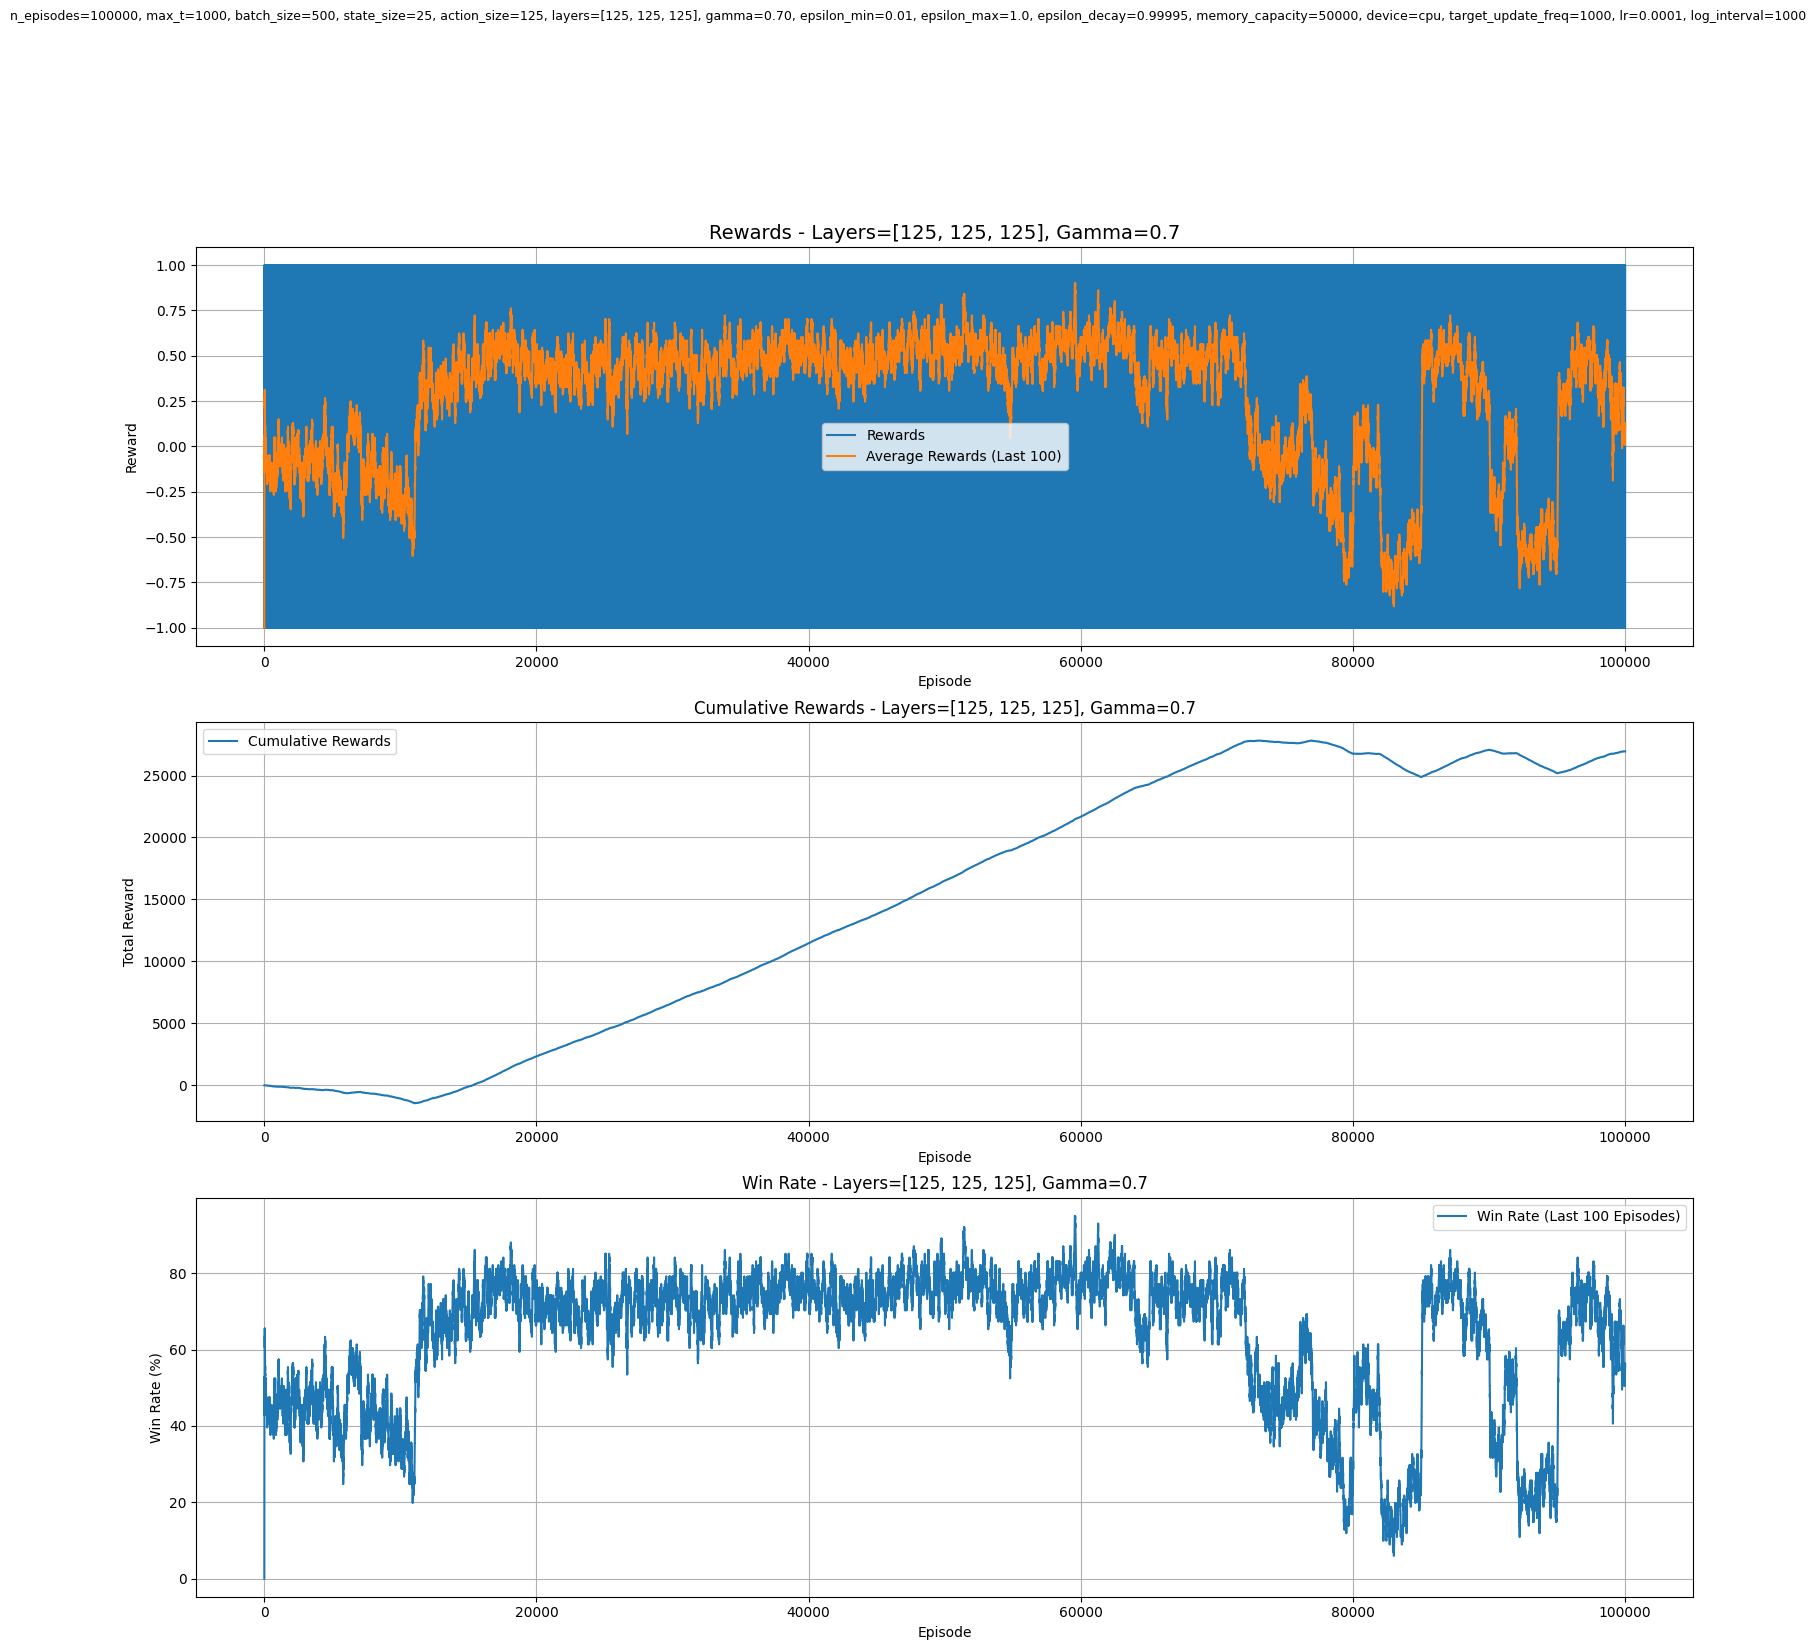

=== Training with LayerStructure=[128, 256, 128], Gamma=0.7, Batch Size=500, Epsilon(max, min)=(1.0, 0.01), mem_cap=50000, Target Update=1000 ===
[1000/100000] Layers=[128, 256, 128], Gamma=0.7, AvgReward(Last100)=-0.12, WinRate(Last100)=44.00%, Eps=0.705
[2000/100000] Layers=[128, 256, 128], Gamma=0.7, AvgReward(Last100)=-0.18, WinRate(Last100)=41.00%, Eps=0.497
[3000/100000] Layers=[128, 256, 128], Gamma=0.7, AvgReward(Last100)=-0.14, WinRate(Last100)=43.00%, Eps=0.360
[4000/100000] Layers=[128, 256, 128], Gamma=0.7, AvgReward(Last100)=0.04, WinRate(Last100)=52.00%, Eps=0.263
[5000/100000] Layers=[128, 256, 128], Gamma=0.7, AvgReward(Last100)=0.12, WinRate(Last100)=56.00%, Eps=0.192
[6000/100000] Layers=[128, 256, 128], Gamma=0.7, AvgReward(Last100)=-0.24, WinRate(Last100)=38.00%, Eps=0.139
[7000/100000] Layers=[128, 256, 128], Gamma=0.7, AvgReward(Last100)=-0.14, WinRate(Last100)=43.00%, Eps=0.104
[8000/100000] Layers=[128, 256, 128], Gamma=0.7, AvgReward(Last100)=-0.38, WinRate(Las

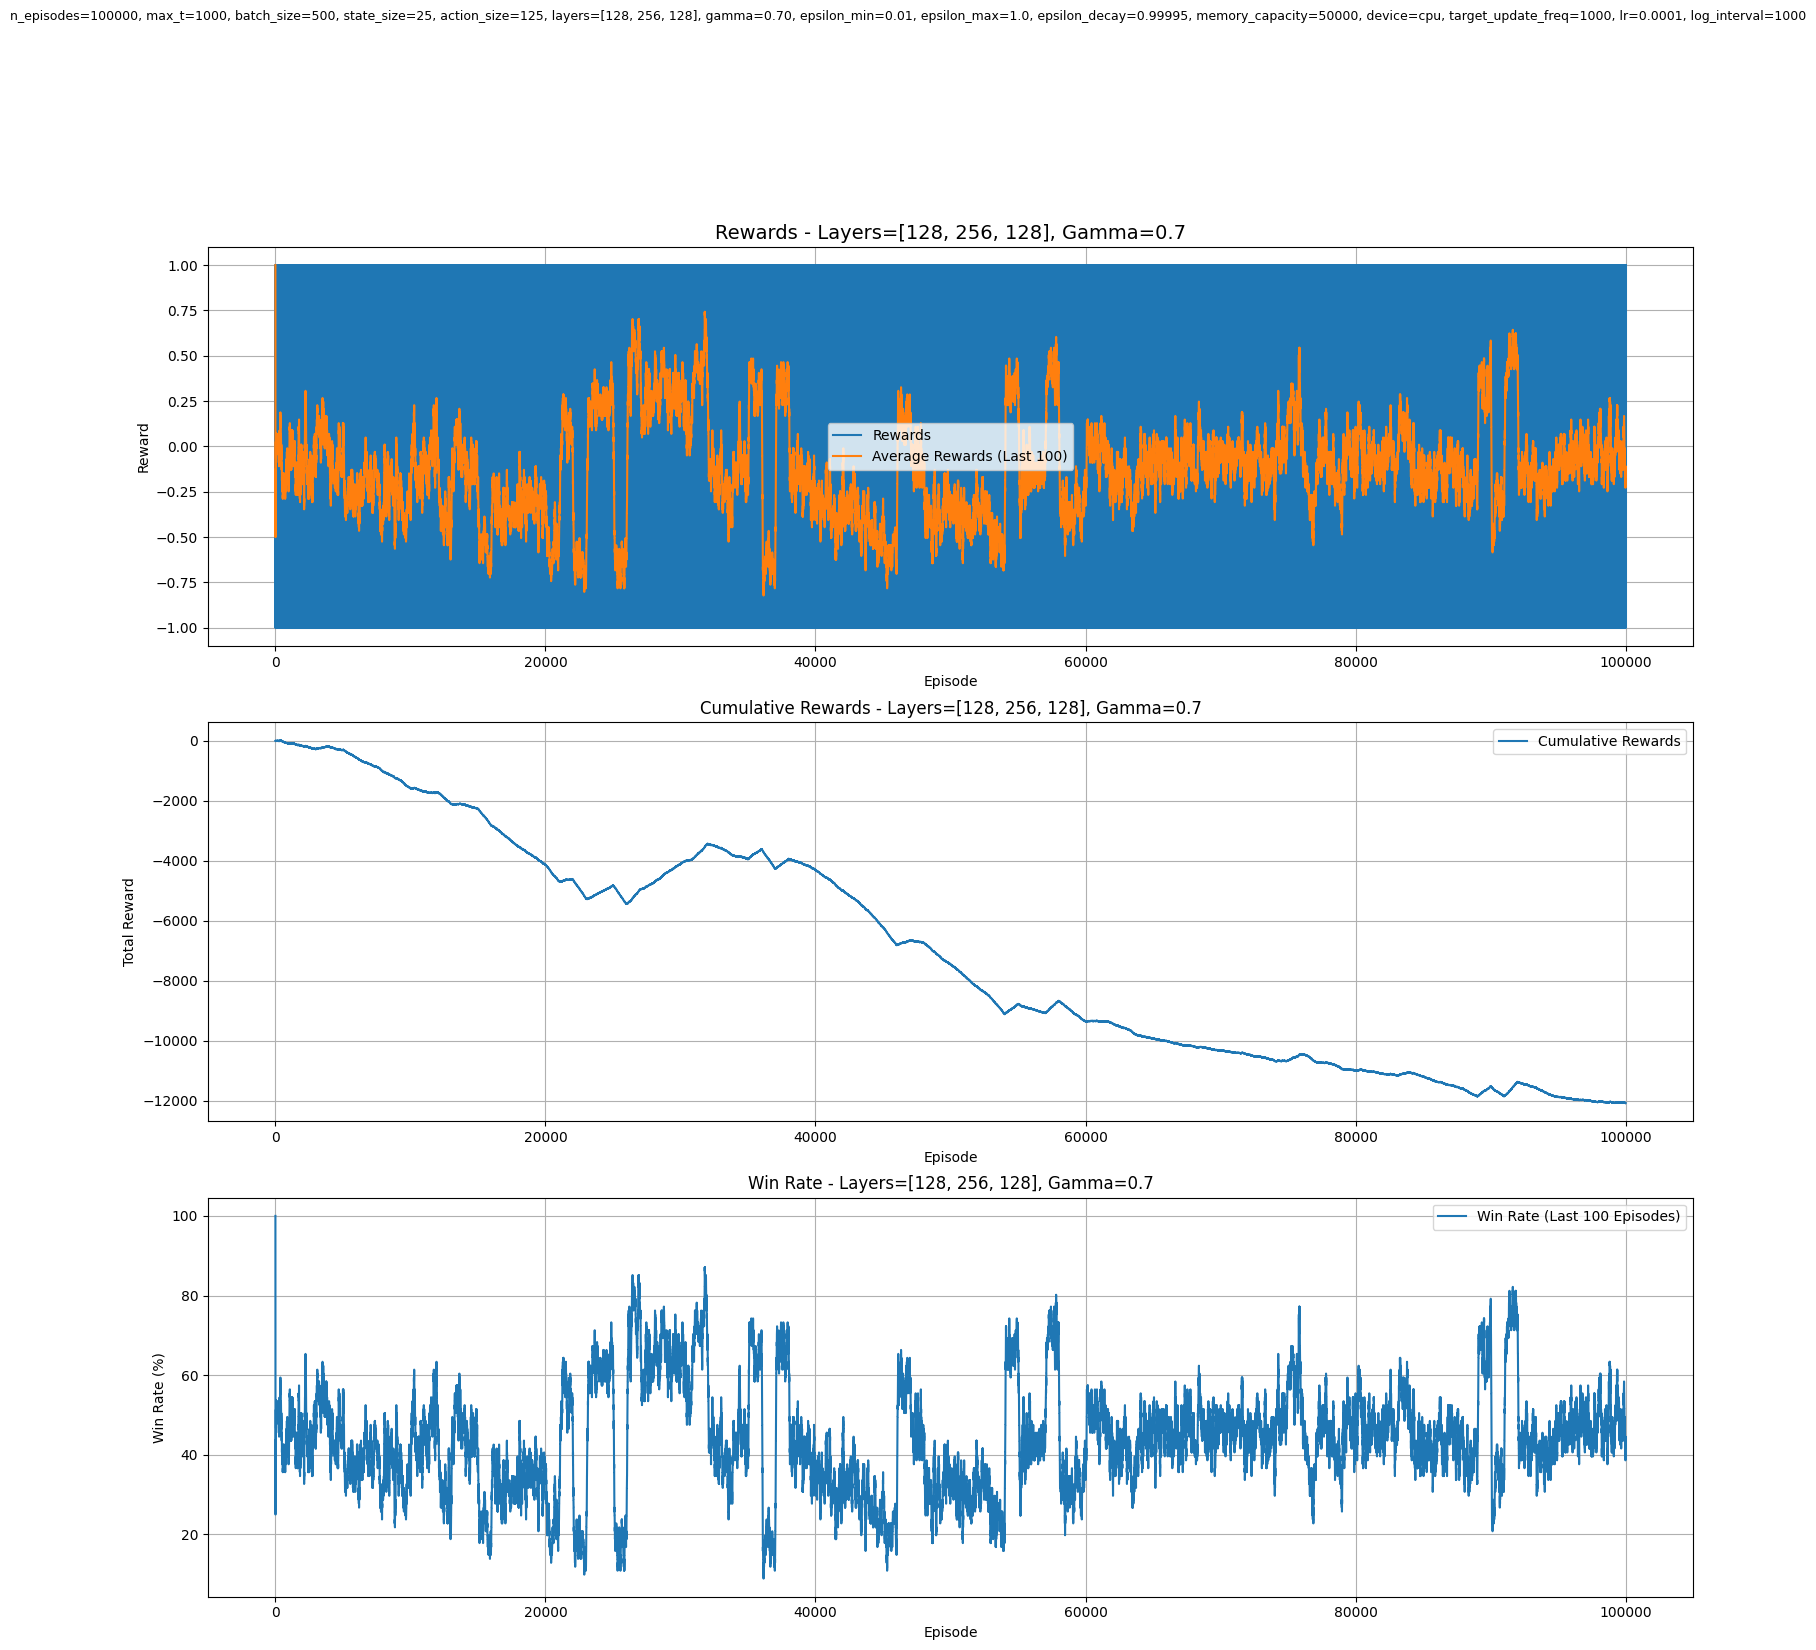

=== Training with LayerStructure=[64, 128, 256, 128], Gamma=0.7, Batch Size=500, Epsilon(max, min)=(1.0, 0.01), mem_cap=50000, Target Update=1000 ===
[1000/100000] Layers=[64, 128, 256, 128], Gamma=0.7, AvgReward(Last100)=-0.16, WinRate(Last100)=42.00%, Eps=0.705
[2000/100000] Layers=[64, 128, 256, 128], Gamma=0.7, AvgReward(Last100)=-0.36, WinRate(Last100)=32.00%, Eps=0.501
[3000/100000] Layers=[64, 128, 256, 128], Gamma=0.7, AvgReward(Last100)=-0.12, WinRate(Last100)=44.00%, Eps=0.366
[4000/100000] Layers=[64, 128, 256, 128], Gamma=0.7, AvgReward(Last100)=-0.06, WinRate(Last100)=47.00%, Eps=0.268
[5000/100000] Layers=[64, 128, 256, 128], Gamma=0.7, AvgReward(Last100)=-0.32, WinRate(Last100)=34.00%, Eps=0.199
[6000/100000] Layers=[64, 128, 256, 128], Gamma=0.7, AvgReward(Last100)=-0.14, WinRate(Last100)=43.00%, Eps=0.152
[7000/100000] Layers=[64, 128, 256, 128], Gamma=0.7, AvgReward(Last100)=-0.30, WinRate(Last100)=35.00%, Eps=0.116
[8000/100000] Layers=[64, 128, 256, 128], Gamma=0.7,

In [ ]:
promising_50_100_125 = TrainAndPlot(n_episodes=100000, max_t=1000, batch_size=500, state_size=25, action_size=125, layers=[[125, 125, 125], [128, 256, 128], [64, 128, 256, 128]], gammas=[0.7], epsilon_min=0.01, epsilon_max=1.0, epsilon_decay=0.99995, memory_capacity=50000, device='cpu', target_update_freq=1000, lr=1e-4, log_interval=1000)
results_50_100_125 = promising_50_100_125.run_experiments();